In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [25]:
import re

In [2]:
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, pairwise_distances
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from pandas.tools.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split as split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler, LabelEncoder

import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [14]:
# use error_bad_lines to get rid of error in line 821
phones = pd.read_csv("phone_dataset.csv", error_bad_lines=False)

C:\Users\ivanv\AppData\Local\Temp\ipykernel_11036\4272890053.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  phones = pd.read_csv("phone_dataset.csv", error_bad_lines=False)
b'Skipping line 821: expected 40 fields, saw 41\nSkipping line 6060: expected 40 fields, saw 41\nSkipping line 6663: expected 40 fields, saw 41\n'


In [ ]:
phones.info()

In [ ]:
# number of nulls in each feature
phones.isnull().sum()

In [ ]:
# number of unique values in each feature
phones.nunique()

In [15]:
# remove the column img_url (a url for the image of the model)
phones.drop(columns=['img_url'],inplace=True)

In [20]:
# switch weight columns into floats
phones.weight_g = pd.to_numeric(phones.weight_g, errors='coerce')
phones.weight_oz = pd.to_numeric(phones.weight_oz, errors='coerce')

In [21]:
# check for mismatch in weight conversion from oz to gr up to 0.03
# how should we treat mismatched weight data ???
phones[abs(0.03527396 * (phones.weight_g) - (phones.weight_oz)) >= 0.03]

,brand,model,network_technology,2G_bands,3G_bands,4G_bands,network_speed,GPRS,EDGE,announced,...,WLAN,bluetooth,GPS,NFC,radio,USB,sensors,battery,colors,approx_price_EUR
18,Acer,Iconia Tab 10 A3-A30,No cellular connectivity,N/A,NaN,NaN,NaN,No,No,2015 April,...,Wi-Fi 802.11 a/b/g/n/ac| dual-band| hotspot,4.0| A2DP,A-GPS only,Yes,No,microUSB 2.0,Accelerometer,Non-removable Li-Ion 5910 mAh battery (22 Wh),Various,250.0
20,Acer,Iconia Tab A3-A20,No cellular connectivity,N/A,NaN,NaN,NaN,No,No,2014 October,...,Wi-Fi 802.11 b/g/n| hotspot,4.0| A2DP,A-GPS only,NaN,No,microUSB 2.0,Accelerometer,Non-removable Li-Po 5910 mAh battery (A3-A20-K...,Black| White,190.0
21,Acer,Iconia Tab A3-A20FHD,No cellular connectivity,N/A,NaN,NaN,NaN,No,No,2014 October,...,Wi-Fi 802.11 b/g/n| hotspot,4.0| A2DP,A-GPS only,NaN,No,microUSB 2.0,Accelerometer,Non-removable Li-Po 5910 mAh battery (A3-A20FH...,Black| White,230.0
48,Acer,Iconia Tab A3,GSM / HSPA,GSM 850 / 900 / 1800 / 1900,HSDPA 850 / 900 / 1900 / 2100,NaN,HSPA 21.1/5.76 Mbps,Yes,Up to 236.8 kbps,2013 September,...,Wi-Fi 802.11 b/g/n| hotspot,4.0| A2DP,Yes with A-GPS,NaN,No,microUSB 2.0| USB Host,Accelerometer| gyro,Non-removable Li-Po 7300 mAh battery (27 Wh),Black/Silver| White,190.0
52,Acer,Liquid Z2,GSM / HSPA,GSM 850 / 900 / 1800 / 1900 - SIM 1 & SIM 2 (d...,HSDPA 900 / 2100,NaN,HSPA 7.2/5.76 Mbps,Yes,Yes,2013 February,...,Wi-Fi 802.11 b/g/n| hotspot,3.0| A2DP,Yes with A-GPS,NaN,FM radio| RDS,microUSB 2.0,Accelerometer| proximity,Removable Li-Ion 1300 mAh battery,Black| Black/White,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7861,verykool,T7445,GSM / HSPA,GSM 850 / 900 / 1800 / 1900 - SIM1 & SIM 2,HSDPA 850 / 1900,NaN,HSPA 21.1/5.76 Mbps,Yes,Yes,2017 June,...,Wi-Fi 802.11 b/g/n| Wi-Fi Direct| hotspot,4.0| A2DP| LE,Yes with A-GPS,NaN,FM radio,microUSB 2.0,Accelerometer,Li-Po 2500 mAh battery,Black,NaN
8078,Vodafone,Smart Tab III 10.1,GSM / HSPA,GSM 850 / 900 / 1800 / 1900,HSDPA 850 / 900 / 1900 / 2100,NaN,HSPA,Yes,Yes,2013 October,...,Wi-Fi 802.11 b/g/n| hotspot,4.0| A2DP| EDR,Yes with A-GPS,NaN,No,microUSB 2.0,Accelerometer,Non-removable Li-Ion battery,Black,NaN
8083,Vodafone,Smart Tab II 10,GSM / HSPA,GSM 900 / 1800 / 1900,HSDPA 900 / 2100,NaN,HSPA,Yes,Yes,2012 November,...,Wi-Fi 802.11 b/g/n| hotspot| DLNA,4.0| A2DP,Yes with A-GPS,NaN,No,2.0,Accelerometer,Non-removable Li-Ion 6340 mAh battery,Gray,270.0
8300,XOLO,Tab,GSM / HSPA,GSM 850 / 900 / 1800 / 1900,HSDPA 2100,NaN,HSPA 21.1/5.76 Mbps,Yes,Yes,2013 September,...,Wi-Fi 802.11 b/g/n| hotspot,3.0,Yes with A-GPS,NaN,FM radio,microUSB 2.0,Accelerometer,Non-removable Li-Ion 4000 mAh battery,White,120.0


In [22]:
# check what type of strings show up in battery column
phones.battery.head()

0    Non-removable Li-Ion 3400 mAh battery (12.92 Wh)
1                    Removable Li-Po 4080 mAh battery
2                   Removable Li-Ion 2000 mAh battery
3                        Non-removable Li-Ion battery
4                    Removable Li-Po 4020 mAh battery
Name: battery, dtype: object

In [23]:
# a function to turn removable battery data into a boolean feature
def removable(battery):
    if battery[0] == 'Removable':
        return True
    elif battery[0] == 'Non-removable':
        return False
    else:
        return np.nan

In [27]:
# looking for regular expressions in battery column strings
# the method 'findall' returns a list with a single element. that element is a tuple of the regular expressions found
a = phones.battery.astype(str).apply(lambda x: 
                                        (re.findall('(Non-removable|Removable|)\s*(Li-Ion|Li-Po|Li-ion|Li-po|NiMH|)\s*(\d*)',x))) 

phones['battery_removable'] = a.apply(lambda x: removable(x[0])) # the first regex indicates 'removable' / 'non-removable'
phones['battery_type'] = a.apply(lambda x: (x[0])[1]) # the second regex indicates 'Li-Ion' / 'Li-Po' / 'Li-ion' / 'Li-po' / 'NiMH'
phones['battery_mah'] = pd.to_numeric(a.apply(lambda x: ((x[0])[2]))) # the third regex gives the numerical data for mah


In [28]:
# the battery column was translated into three new features:
# 1. battery_removable (boolean)
# 2. battery_type (string): Li-Ion / Li-Po / Li-ion / Li-po / NiMH
# 3. battery_mah (float)
phones.head()

,brand,model,network_technology,2G_bands,3G_bands,4G_bands,network_speed,GPRS,EDGE,announced,...,NFC,radio,USB,sensors,battery,colors,approx_price_EUR,battery_removable,battery_type,battery_mah
0,Acer,Iconia Talk S,GSM / HSPA / LTE,GSM 850 / 900 / 1800 / 1900 - SIM 1 & SIM 2,HSDPA 850 / 1900 / 2100,LTE band 1(2100)| 3(1800)| 7(2600)| 8(900)| 20...,HSPA 42.2/11.5 Mbps LTE Cat4 150/50 Mbps,Yes,Yes,2016 August,...,NaN,FM radio,microUSB 2.0,Accelerometer| proximity,Non-removable Li-Ion 3400 mAh battery (12.92 Wh),Black,170.0,False,Li-Ion,3400.0
1,Acer,Liquid Z6 Plus,GSM / HSPA / LTE,GSM 850 / 900 / 1800 / 1900 - SIM 1 & SIM 2 (d...,HSDPA,LTE,HSPA 42.2/5.76 Mbps LTE Cat4 150/50 Mbps,Yes,Yes,2016 August,...,NaN,FM radio,microUSB 2.0,Fingerprint (front-mounted)| accelerometer| pr...,Removable Li-Po 4080 mAh battery,Black| White,250.0,True,Li-Po,4080.0
2,Acer,Liquid Z6,GSM / HSPA / LTE,GSM 850 / 900 / 1800 / 1900 - SIM 1 & SIM 2 (d...,HSDPA,LTE,HSPA LTE,Yes,Yes,2016 August,...,NaN,FM radio,microUSB 2.0,Accelerometer| proximity,Removable Li-Ion 2000 mAh battery,Black| White,120.0,True,Li-Ion,2000.0
3,Acer,Iconia Tab 10 A3-A40,No cellular connectivity,N/A,NaN,NaN,NaN,No,No,2016 April,...,NaN,No,microUSB 2.0,Accelerometer,Non-removable Li-Ion battery,Black,230.0,False,Li-Ion,NaN
4,Acer,Liquid X2,GSM / HSPA / LTE,GSM 850 / 900 / 1800 / 1900,HSDPA 900 / 1900 / 2100 - Europe| Taiwan,LTE 800 / 1800 / 2100 / 2600 - Europe,HSPA 42.2/5.76 Mbps LTE Cat4 150/50 Mbps,Yes,Yes,2015 April,...,NaN,FM radio,microUSB 2.0,Accelerometer| proximity| compass,Removable Li-Po 4020 mAh battery,Black| Gold,230.0,True,Li-Po,4020.0


In [29]:
# now we can remove the original battery column...
phones.drop(columns=['battery'],inplace=True)

In [30]:
# begin work on display_resolution feature
phones.display_resolution.head()

0     7.0 inches (~69.8% screen-to-body ratio)
1     5.5 inches (~71.7% screen-to-body ratio)
2                                   5.0 inches
3    10.1 inches (~68.4% screen-to-body ratio)
4     5.5 inches (~69.0% screen-to-body ratio)
Name: display_resolution, dtype: object

In [31]:
# extract regex from display_resolution feature
a = phones.display_resolution.astype(str).apply(lambda x: 
                                        (re.findall('(\d*\.\d*)\s*inches(\s*\(.(\d*\.\d*)|)',x))) 



In [32]:
# look at the empty regexes we got (1233 in total)
a[a.apply(lambda x: len(x) == 0)]

350     []
351     []
374     []
381     []
383     []
        ..
8595    []
8616    []
8617    []
8621    []
8627    []
Name: display_resolution, Length: 1233, dtype: object

In [33]:
# there are origianlly 1214 NaNs in the display_resolution column 
# regex did not work for additional 19 values
# let's look at those values ...
phones.display_resolution.isnull().sum()

1214

In [34]:
# here are the 19 "weird" display_resolution values that are not NaNs
# conclusion: we're not missing anything by getting the empty regex for these
phones.display_resolution[~phones.display_resolution.isnull() & a.apply(lambda x: len(x) == 0)]

1410             | -
2524             | -
2600             | -
2664             | -
2668             | -
3570             | -
3884             | -
3887             | -
3889             | -
5865    | 26 x 28 mm
7586             | -
7587             | -
7598             | -
7599             | -
7600             | -
7601             | -
7731    | 53 x 40 mm
8105             | -
8572             | -
Name: display_resolution, dtype: object

In [35]:
# functions to parse data from display_resolution regex

def display_resolution_inches(regex):
    if regex == []:
        return np.nan
    else:
        return float((regex[0])[0])
    
def screen_to_body_ratio(regex):
    if regex == []:
        return np.nan
    elif regex[0][-1] is None:
        return np.nan
    else:
        return (regex[0][-1])

In [37]:
phones['display_resolution_inches'] = a.apply(lambda x: display_resolution_inches(x))
phones['screen_to_body_ratio_%'] = pd.to_numeric(a.apply(lambda x: screen_to_body_ratio(x)))

In [38]:
# the display_resolution was translated into two new features:
# 1. display_resolution_inches (float)
# 2. screen_to_body_ratio_% (float)
phones.head()

,brand,model,network_technology,2G_bands,3G_bands,4G_bands,network_speed,GPRS,EDGE,announced,...,radio,USB,sensors,colors,approx_price_EUR,battery_removable,battery_type,battery_mah,display_resolution_inches,screen_to_body_ratio_%
0,Acer,Iconia Talk S,GSM / HSPA / LTE,GSM 850 / 900 / 1800 / 1900 - SIM 1 & SIM 2,HSDPA 850 / 1900 / 2100,LTE band 1(2100)| 3(1800)| 7(2600)| 8(900)| 20...,HSPA 42.2/11.5 Mbps LTE Cat4 150/50 Mbps,Yes,Yes,2016 August,...,FM radio,microUSB 2.0,Accelerometer| proximity,Black,170.0,False,Li-Ion,3400.0,7.0,69.8
1,Acer,Liquid Z6 Plus,GSM / HSPA / LTE,GSM 850 / 900 / 1800 / 1900 - SIM 1 & SIM 2 (d...,HSDPA,LTE,HSPA 42.2/5.76 Mbps LTE Cat4 150/50 Mbps,Yes,Yes,2016 August,...,FM radio,microUSB 2.0,Fingerprint (front-mounted)| accelerometer| pr...,Black| White,250.0,True,Li-Po,4080.0,5.5,71.7
2,Acer,Liquid Z6,GSM / HSPA / LTE,GSM 850 / 900 / 1800 / 1900 - SIM 1 & SIM 2 (d...,HSDPA,LTE,HSPA LTE,Yes,Yes,2016 August,...,FM radio,microUSB 2.0,Accelerometer| proximity,Black| White,120.0,True,Li-Ion,2000.0,5.0,NaN
3,Acer,Iconia Tab 10 A3-A40,No cellular connectivity,N/A,NaN,NaN,NaN,No,No,2016 April,...,No,microUSB 2.0,Accelerometer,Black,230.0,False,Li-Ion,NaN,10.1,68.4
4,Acer,Liquid X2,GSM / HSPA / LTE,GSM 850 / 900 / 1800 / 1900,HSDPA 900 / 1900 / 2100 - Europe| Taiwan,LTE 800 / 1800 / 2100 / 2600 - Europe,HSPA 42.2/5.76 Mbps LTE Cat4 150/50 Mbps,Yes,Yes,2015 April,...,FM radio,microUSB 2.0,Accelerometer| proximity| compass,Black| Gold,230.0,True,Li-Po,4020.0,5.5,69.0


In [39]:
# now we can remove the original display_resolution column...
phones.drop(columns=['display_resolution'],inplace=True)

In [40]:
phones.dimentions.isnull().sum()

19

In [41]:
# weird '-' as a value in 'dimentions'
# there are 331 '-' and 19 nulls, that leaves us with 8628-331-19=8278 valid values
phones.dimentions[phones.dimentions == '-'].value_counts()

-    331
Name: dimentions, dtype: int64

In [42]:
# extract regex from "dimentions" feature
# eliminate 'mm' to include min value of thickness, we get two tuples, one for mm and one for inches
a = phones.dimentions.astype(str).apply(lambda x: 
                                        (re.findall('(\d*\.\d*|\d*)\sx\s(\d*\.\d*|\d*)\sx\s(\d*\.\d*|\d*)',x))) 
# a = phones.dimentions.astype(str).apply(lambda x: 
#                                         (re.findall('(\d*\.\d*|\d*)\sx\s(\d*\.\d*|\d*)\sx\s(\d*\.\d*|\d*)\smm',x))) 


In [43]:
a.head()

0     [(191.7, 101, 9.4), (7.55, 3.98, 0.37)]
1    [(153.8, 75.6, 8.5), (6.06, 2.98, 0.33)]
2                                          []
3      [(259, 167, 8.9), (10.20, 6.57, 0.35)]
4    [(153.3, 78.8, 8.5), (6.04, 3.10, 0.33)]
Name: dimentions, dtype: object

In [44]:
phones.dimentions.head()

0     191.7 x 101 x 9.4 mm (7.55 x 3.98 x 0.37 in)
1    153.8 x 75.6 x 8.5 mm (6.06 x 2.98 x 0.33 in)
2                                                -
3      259 x 167 x 8.9 mm (10.20 x 6.57 x 0.35 in)
4    153.3 x 78.8 x 8.5 mm (6.04 x 3.10 x 0.33 in)
Name: dimentions, dtype: object

In [45]:
# check which regex reads failed (but not because there was a NaN or '-')
phones.dimentions[a.apply(lambda x: len(x) == 0) & ~phones.dimentions.isnull() & (phones.dimentions != '-')]

35                    8.9 mm thickness
36                    8.9 mm thickness
37                    8.9 mm thickness
182                   9.9 mm thickness
722                   6.9 mm thickness
725                   8.9 mm thickness
741       205.2 mm x 136.4 mm x X mm x
1093                  9.5 mm thickness
1930                  9.5 mm thickness
2203                    8 mm thickness
2831                      247 x 179 mm
2833                  9.6 mm thickness
2869                  8.5 mm thickness
3383                 11.9 mm thickness
3741                  5.1 mm thickness
3743                  6.3 mm thickness
3749                  8.5 mm thickness
3758                    7 mm thickness
3776                  6.9 mm thickness
4368                            100 cc
4982     118 x 42-50 x 18-21 mm| 98 cc
5001    142 x 50-58 x 23-27 mm| 159 cc
5071                  7.3 mm thickness
5128                  7.9 mm thickness
5169                  8.4 mm thickness
5200                    8

In [46]:
# process mm thickness-only info
b = phones.dimentions.astype(str).apply(lambda x: 
                                        (re.findall('(\d*\.\d*|\d*)\smm\sthickness',x)))

In [47]:
# convert regex data into numerical data
# return value as a list
def dimension_conversion(regex):
    if len(regex) == 0: # empty regex
        return []
    elif len(regex) == 1 & isinstance(regex[0],str): # regex coming from thickneww only data
        new_regex = []
        try:            
            new_regex.append(float(regex[0]))
        except:
            pass
        return new_regex
    elif (len(regex) >= 1) & isinstance(regex[0],tuple): # regex coming from full dimension data
        new_regex = list(regex[0])
        for i in range(len(new_regex)):
            try:
                new_regex[i] = float(regex[0][i])
            except:
                pass
        return new_regex
    else:
        return []

In [48]:
# combine dimensions data
# data that did not match one of the following (but wasn't NaN) was converted into NaN
# 1. number x number x number mm
# 2. number mm thickness
# 3. '-'
c = a.apply(lambda x: dimension_conversion(x)) + b.apply(lambda x: dimension_conversion(x))

In [49]:
# define functions to extract data on each dimension
def length(x):
    if len(x) == 3:
        if x[0] is not None:
            return x[0]
        else:
            return np.nan
    else:
        return np.nan
    
def width(x):
    if len(x) == 3:
        if x[1] is not None:
            return x[1]
        else:
            return np.nan
    else:
        return np.nan
    
def thickness(x):
    if len(x) == 3:
        if x[2] is not None:
            return x[2]
        else:
            return np.nan
    elif len(x) == 1:
        if x[0] is not None:
            return x[0]
        else:
            return np.nan
    else:
        return np.nan

In [50]:
length = c.apply(lambda x: length(x))

In [51]:
width = c.apply(lambda x: width(x))

In [52]:
thickness = c.apply(lambda x: thickness(x))

In [53]:
# test thickness function against original b values
thickness[c.apply(lambda x: len(x) == 1)]

35       8.9
36       8.9
37       8.9
182      9.9
722      6.9
725      8.9
1093     9.5
1930     9.5
2203     8.0
2833     9.6
2869     8.5
3383    11.9
3741     5.1
3743     6.3
3749     8.5
3758     7.0
3776     6.9
5071     7.3
5128     7.9
5169     8.4
5200     8.0
5201     7.9
5689     8.5
5690    11.0
5781     8.3
5786     9.3
8401     8.3
8404     7.8
8411     7.9
8559     7.8
Name: dimentions, dtype: object

In [54]:
# test thickness function against NaNs
thickness[c.apply(lambda x: len(x) == 0)]

2       NaN
5       NaN
146     NaN
147     NaN
186     NaN
       ... 
8584    NaN
8589    NaN
8590    NaN
8592    NaN
8611    NaN
Name: dimentions, Length: 358, dtype: object

In [55]:
phones['length_mm'] = length
phones['width_mm'] = width
phones['thickness_mm'] = thickness

In [56]:
phones.drop(columns=['dimentions'],inplace=True)

In [57]:
phones.internal_memory.value_counts()

8 GB                                     919
4 GB                                     902
16 GB                                    815
32 GB                                    290
512 MB                                   271
                                        ... 
4.3 MB                                     1
256 GB                                     1
4.2 MB                                     1
16GB (3G model); 16/32 GB (LTE model)      1
512 MB (152 MB user available)             1
Name: internal_memory, Length: 395, dtype: int64

In [58]:
# process internal_memory info
a = phones.internal_memory.astype(str).apply(lambda x: 
                                        (re.findall('(?i)(\d*|\d*\.\d*)\/*(\d*)\/*(\d*)\s(?=GB)|(\d*|\d*\.\d*)\/*(\d*)\/*(\d*)\s(?=MB)|(\d*|\d*\.\d*)\/*(\d*)\/*(\d*)\s(?=KB)',x,re.IGNORECASE)))

In [59]:
a.head(10)

0      [(16, 32, , , , , , , )]
1        [(32, , , , , , , , )]
2         [(8, , , , , , , , )]
3    [(16, 32, 64, , , , , , )]
4        [(32, , , , , , , , )]
5        [(32, , , , , , , , )]
6        [(16, , , , , , , , )]
7         [(8, , , , , , , , )]
8      [(32, 64, , , , , , , )]
9        [(32, , , , , , , , )]
Name: internal_memory, dtype: object

In [60]:
(a.iloc[3][0][3]=='')

True

In [61]:
# functions for extracting internal_memory string data broken into types: GB / MB / KB

def GB(regex):
    gb = []
    for i in range(3):
        for j in range(2):
            try:
                gb.append(float(regex[j][i])) # GB found in regex groups 1, 2, and 3
            except:
                pass
    return gb

def MB(regex):
    mb = []
    for i in range(3):
        for j in range(2):
            try:
                mb.append(float(regex[j][i+3])) # MB found in regex groups 4,5,6
            except:
                pass
    return mb

def KB(regex):
    kb = []
    for i in range(3):
        for j in range(2):
            try:
                kb.append(float(regex[j][i+6])) # KB found in regex groups 7,8,9
            except:
                pass
    return kb

def GB_MB_KB(regex):
    return [GB(regex),MB(regex),KB(regex)]

In [62]:
a.apply(lambda x: GB_MB_KB(x))

0             [[16.0, 32.0], [], []]
1                   [[32.0], [], []]
2                    [[8.0], [], []]
3       [[16.0, 32.0, 64.0], [], []]
4                   [[32.0], [], []]
                    ...             
8623                    [[], [], []]
8624                    [[], [], []]
8625                    [[], [], []]
8626                    [[], [], []]
8627                 [[], [4.0], []]
Name: internal_memory, Length: 8628, dtype: object

In [63]:
# test internal_memory with mixed types (eg, GB and MB)
a[a.apply(lambda x: len(x) == 2)]

165         [(8, , , , , , , , ), (5, , , , , , , , )]
166         [(8, , , , , , , , ), (5, , , , , , , , )]
171     [(16, , , , , , , , ), (12.9, , , , , , , , )]
180      [(, , , 128, , , , , ), (, , , 64, , , , , )]
197       [(16, , , , , , , , ), (32, , , , , , , , )]
                             ...                      
8544      [(4, , , , , , , , ), (2.3, , , , , , , , )]
8545      [(4, , , , , , , , ), (2.6, , , , , , , , )]
8547      [(4, , , , , , , , ), (2.5, , , , , , , , )]
8564      [(4, , , , , , , , ), (2.5, , , , , , , , )]
8578    [(, , , 512, , , , , ), (, , , 152, , , , , )]
Name: internal_memory, Length: 141, dtype: object

In [64]:
# apply BG_MB_KB to mixed type internal_memory strings to check validity
a[a.apply(lambda x: len(x) == 2)].apply(lambda x: GB_MB_KB(x))

165         [[8.0, 5.0], [], []]
166         [[8.0, 5.0], [], []]
171       [[16.0, 12.9], [], []]
180      [[], [128.0, 64.0], []]
197       [[16.0, 32.0], [], []]
                  ...           
8544        [[4.0, 2.3], [], []]
8545        [[4.0, 2.6], [], []]
8547        [[4.0, 2.5], [], []]
8564        [[4.0, 2.5], [], []]
8578    [[], [512.0, 152.0], []]
Name: internal_memory, Length: 141, dtype: object

In [65]:
a_GB = a.apply(lambda x: GB_MB_KB(x)[0])
a_MB = a.apply(lambda x: GB_MB_KB(x)[1])
a_KB = a.apply(lambda x: GB_MB_KB(x)[2])

In [66]:
a_GB.head()

0          [16.0, 32.0]
1                [32.0]
2                 [8.0]
3    [16.0, 32.0, 64.0]
4                [32.0]
Name: internal_memory, dtype: object

In [67]:
a_MB.iloc[[180,1354,7351,7381]]

180      [128.0, 64.0]
1354    [256.0, 123.0]
7351           [300.0]
7381           [320.0]
Name: internal_memory, dtype: object

In [68]:
# test KB types
a_KB[a.apply(lambda x: GB_MB_KB(x)[2] != [])]

345     [500.0]
450     [512.0]
628     [650.0]
932     [256.0]
3479    [500.0]
3549    [350.0]
3552    [350.0]
4265     [70.0]
4266     [20.0]
4277    [500.0]
4297    [500.0]
4319    [640.0]
4403    [512.0]
4419    [128.0]
4961    [484.0]
4967    [725.0]
4970    [725.0]
4971    [725.0]
5223    [512.0]
5233    [512.0]
5320    [750.0]
5473    [400.0]
5542    [256.0]
5892    [240.0]
5905    [240.0]
6452    [351.0]
6453    [597.0]
6634    [500.0]
6701    [480.0]
6712    [400.0]
6739    [600.0]
6830    [600.0]
6832    [600.0]
6833    [600.0]
6834    [600.0]
6853    [600.0]
6875    [600.0]
6876    [600.0]
6877    [600.0]
7016    [300.0]
7203    [550.0]
7215    [120.0]
7217    [400.0]
7523    [650.0]
7524    [500.0]
7525    [500.0]
7530    [600.0]
7540    [600.0]
7541    [400.0]
Name: internal_memory, dtype: object

In [69]:
# generate three seperate columns including all internal_memory options of a given type (GB / MB / KB) as floats
# in the next step, turn categorical...
phones["internal_memory_BG"] = a_GB 
phones["internal_memory_MB"] = a_MB
phones["internal_memory_KB"] = a_KB

In [70]:
phones.RAM.value_counts()

1 GB RAM                                                               1449
512 MB RAM                                                              862
2 GB RAM                                                                618
3 GB RAM                                                                267
256 MB RAM                                                              241
                                                                       ... 
3 GB RAM - ATH-AL00 model                                                 1
2 GB RAM - KIW-CL00| KIW-TL00| KIW-TL00H| KII-L21| KII-L22| KII-L23       1
3 GB RAM - NXT-L09| NXT-L29                                               1
3 GB RAM (EVA-L19/EVA-L09)                                                1
2 GB RAM/ 16 GB| 2 GB RAM (model for China)                               1
Name: RAM, Length: 209, dtype: int64

In [71]:
phones_new=phones[phones['approx_price_EUR'].isnull()==0]

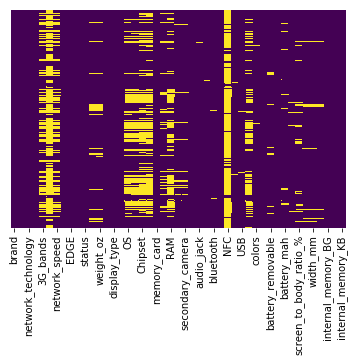

In [57]:
sns.heatmap(phones_new.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [72]:
phones_new.drop('NFC',axis=1,inplace=True)

C:\Users\ivanv\AppData\Local\Temp\ipykernel_11036\2423259737.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phones_new.drop('NFC',axis=1,inplace=True)


In [73]:
phones_new.drop('4G_bands',axis=1,inplace=True)

C:\Users\ivanv\AppData\Local\Temp\ipykernel_11036\399891543.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phones_new.drop('4G_bands',axis=1,inplace=True)


In [74]:
# GPU  (graphics processing unit) column will be categorial type

a_regex = '(""|Adreno|Intel|Mali|Broadcom|PowerVR|ULP|Vivante|Nvidia|Kepler|3D|Mediatek|SGX531u|VideoCore)'
GPU_replacements = {'':0, 'Adreno':1,'Intel':2,'Mali':3,'Broadcom':4,'PowerVR':5,'ULP':6,'Vivante':7,'Nvidia':8,'Kepler':9
                   ,'3D':10,'Mediatek':11,'SGX531u':12,'VideoCore':13}

#Extract Using Regex
phones_new['GPU_new'] = phones_new['GPU'].str.extract(a_regex).fillna('')
#Look up values from dictionary
phones_new['GPU_new'] = phones_new['GPU_new'].apply(lambda x: GPU_replacements.get(x,''))
#Use default value from other coumn if no other value


C:\Users\ivanv\AppData\Local\Temp\ipykernel_11036\2184004960.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phones_new['GPU_new'] = phones_new['GPU'].str.extract(a_regex).fillna('')
C:\Users\ivanv\AppData\Local\Temp\ipykernel_11036\2184004960.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phones_new['GPU_new'] = phones_new['GPU_new'].apply(lambda x: GPU_replacements.get(x,''))


In [75]:
phones_new['GPU_new'].value_counts()

0     2361
1     1249
3      754
5      493
6       87
4       22
7       15
2       11
10       5
12       2
8        1
9        1
11       1
13       1
Name: GPU_new, dtype: int64

In [76]:
# indexing brands
brands=[]
phones_new['brand_idx']=999
x=1
brands.append(phones_new['brand'].iloc[0])
phones_new['brand_idx'].iloc[0]=1
i=1
for i in range(1,len(phones_new['brand'])-1):
    if phones_new['brand'].iloc[i] in brands:
        phones_new['brand_idx'].iloc[i]=brands.index(phones_new['brand'].iloc[i])+1
    else:
        x=x+1
        brands.append(phones_new['brand'].iloc[i])
        phones_new['brand_idx'].iloc[i]=x

C:\Users\ivanv\AppData\Local\Temp\ipykernel_11036\3148670005.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phones_new['brand_idx']=999
C:\Users\ivanv\AppData\Local\Temp\ipykernel_11036\3148670005.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phones_new['brand_idx'].iloc[0]=1
C:\Users\ivanv\AppData\Local\Temp\ipykernel_11036\3148670005.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

In [63]:
# indexing models - irrelavant
# models=[]
# phones_new['model_idx']=999
# x=1
# models.append(phones_new['model'].iloc[0])
# phones_new['model_idx'].iloc[0]=1
# i=1
# for i in range(1,len(df_new['model'])-1):
#     if phones_new['model'].iloc[i] in models:
#         phones_new['model_idx'].iloc[i]=models.index(phones_new['model'].iloc[i])+1
#     else:
#         x=x+1
#         models.append(phones_new['model'].iloc[i])
#         phones_new['model_idx'].iloc[i]=x

In [77]:
phones_new['year'] = phones_new['announced'].str.extract('(\d\d\d\d)', expand=True)
phones_new['year'].fillna(phones_new['year'].value_counts().index[0],inplace=True)
phones_new['year'].value_counts()

C:\Users\ivanv\AppData\Local\Temp\ipykernel_11036\119531854.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phones_new['year'] = phones_new['announced'].str.extract('(\d\d\d\d)', expand=True)
C:\Users\ivanv\AppData\Local\Temp\ipykernel_11036\119531854.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phones_new['year'].fillna(phones_new['year'].value_counts().index[0],inplace=True)


2014    685
2013    599
2012    540
2015    526
2011    519
2010    421
2016    387
2009    350
2008    297
2007    273
2006    160
2017    150
2005     80
2004     14
2003      2
Name: year, dtype: int64

In [78]:
a_regex = '(January|February|March|April|May|June|July|August|September|October|November|December)'
month_replacements = {'January':1, 'February':2,
            'March':3,'April':4 ,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11, 'December':12}

#Extract Using Regex
phones_new['Month'] = phones_new['announced'].str.extract(a_regex).fillna('')
#Look up values from dictionary
phones_new['Month'] = phones_new['Month'].apply(lambda x: month_replacements.get(x,''))
#Use default value from other coumn if no other value

C:\Users\ivanv\AppData\Local\Temp\ipykernel_11036\3491606548.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phones_new['Month'] = phones_new['announced'].str.extract(a_regex).fillna('')
C:\Users\ivanv\AppData\Local\Temp\ipykernel_11036\3491606548.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phones_new['Month'] = phones_new['Month'].apply(lambda x: month_replacements.get(x,''))


In [79]:
# create a list of ratio of each month in data to complete missing data
ratio=[]
for i in range (1,13):
    a=(phones_new['Month']==i).sum()/(sum(phones_new['Month'].value_counts())-(phones_new['Month']=="").sum())*(phones_new['Month']=="").sum()
    ratio.append(round(a))
ratio
# sum(df_new['Month'].value_counts())

[44, 63, 29, 33, 33, 44, 27, 40, 49, 46, 29, 23]

In [80]:
#creating new column-Month_new to replace "" with the number of month by ratio
phones_new['Month_new']=999
j=0 # place in list
k=1
l=1
for i in range(0, len(phones_new)):
    if phones_new['Month'].iloc[i]=="":
        if k<=ratio[j]:
            phones_new['Month_new'].iloc[i]=l
            k=k+1
        else:
            k=1
            l=l+1
            j=j+1
    else:
         phones_new['Month_new'].iloc[i]=phones_new['Month'].iloc[i]

C:\Users\ivanv\AppData\Local\Temp\ipykernel_11036\2338706264.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phones_new['Month_new']=999
C:\Users\ivanv\AppData\Local\Temp\ipykernel_11036\2338706264.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phones_new['Month_new'].iloc[i]=phones_new['Month'].iloc[i]
C:\Users\ivanv\AppData\Local\Temp\ipykernel_11036\2338706264.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [81]:
phones_new['Month_new'].replace(999,12,inplace=True)
phones_new['Month_new'].value_counts()

C:\Users\ivanv\AppData\Local\Temp\ipykernel_11036\1280817381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phones_new['Month_new'].replace(999,12,inplace=True)


2     685
9     533
10    497
6     483
1     478
8     434
4     361
5     356
3     317
11    312
7     292
12    255
Name: Month_new, dtype: int64

In [82]:
#creating a binary column - GPS_new if there is a GPS in model
check_list = ['Yes', 'GPS']
regstr = '|'.join(check_list)
phones_new['GPS_new']=phones_new['GPS']
# df_new['GPS_new'] = np.where(df_new['GPS'].isin(check_list),'YES','NO')
phones_new['GPS_new']=phones_new['GPS_new'].str.contains(regstr, case=False, na=False)

C:\Users\ivanv\AppData\Local\Temp\ipykernel_11036\3886080971.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phones_new['GPS_new']=phones_new['GPS']
C:\Users\ivanv\AppData\Local\Temp\ipykernel_11036\3886080971.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phones_new['GPS_new']=phones_new['GPS_new'].str.contains(regstr, case=False, na=False)


In [83]:
phones_new['primary_cam_MP']=phones_new["primary_camera"].str.split(' ',expand=True)[0]
phones_new['primary_cam_MP'].fillna(0,inplace=True)
phones_new['primary_cam_MP'].replace('2MP',2,inplace=True)
phones_new['primary_cam_MP'].replace('5MP|',5,inplace=True)
phones_new['primary_cam_MP'].replace('600',0,inplace=True)
phones_new['primary_cam_MP'].replace(['SVGA','Yes.','QVGA','Yes|','CIF','No','VGA|','Yes','Dual','VGA'],0,inplace=True)



C:\Users\ivanv\AppData\Local\Temp\ipykernel_11036\3436266700.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phones_new['primary_cam_MP']=phones_new["primary_camera"].str.split(' ',expand=True)[0]
C:\Users\ivanv\AppData\Local\Temp\ipykernel_11036\3436266700.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phones_new['primary_cam_MP'].fillna(0,inplace=True)
C:\Users\ivanv\AppData\Local\Temp\ipykernel_11036\3436266700.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:

In [84]:
phones_new['secondary_cam_MP']=phones_new["secondary_camera"].str.split(' ',expand=True)[0]
phones_new['secondary_cam_MP'].fillna(0,inplace=True)

C:\Users\ivanv\AppData\Local\Temp\ipykernel_11036\207009529.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phones_new['secondary_cam_MP']=phones_new["secondary_camera"].str.split(' ',expand=True)[0]
C:\Users\ivanv\AppData\Local\Temp\ipykernel_11036\207009529.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phones_new['secondary_cam_MP'].fillna(0,inplace=True)


In [85]:
phones_new['secondary_cam_MP'].replace('8MP',8,inplace=True)
phones_new['secondary_cam_MP'].replace('1.3MP',1.3,inplace=True)
phones_new['secondary_cam_MP'].replace(['No','Yes','QCIF','0.','QVGA','Videocalling','CIF','0','VGA|','HD','Dual','VGA','Spy','VGA@15fps','QCIF@15fps','VGA/','720p','Videocall',],0,inplace=True)

C:\Users\ivanv\AppData\Local\Temp\ipykernel_11036\3243328648.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phones_new['secondary_cam_MP'].replace('8MP',8,inplace=True)
C:\Users\ivanv\AppData\Local\Temp\ipykernel_11036\3243328648.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phones_new['secondary_cam_MP'].replace('1.3MP',1.3,inplace=True)
C:\Users\ivanv\AppData\Local\Temp\ipykernel_11036\3243328648.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

In [86]:
# OS  (Operation System) column will be int type

a_regex = '(""|Android|Windows|Firefox|iOS|BlackBerry|Linux|webOS|Sailfish|Nokia|Symbian|Tizen)'
OS_replacements = {'':0, 'Android':1,'Windows':2,'Firefox':3,'iOS':4,'BlackBerry':5,'Linux':6,'webOS':7,'Sailfish':8,'Nokia':9
                   ,'Symbian':10,'Tizen':11}

#Extract Using Regex
phones_new['OS'] = phones_new['OS'].str.extract(a_regex).fillna('')
#Look up values from dictionary
phones_new['OS'] = phones_new['OS'].apply(lambda x: OS_replacements.get(x,''))
#Use default value from other coumn if no other value


C:\Users\ivanv\AppData\Local\Temp\ipykernel_11036\268224.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phones_new['OS'] = phones_new['OS'].str.extract(a_regex).fillna('')
C:\Users\ivanv\AppData\Local\Temp\ipykernel_11036\268224.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phones_new['OS'] = phones_new['OS'].apply(lambda x: OS_replacements.get(x,''))


In [87]:
# drop rows with NAN and 0
phones_new=phones_new[phones_new['length_mm']!=0]
phones_new=phones_new[phones_new['length_mm']!=""]

In [88]:
#change data types (length_mm,Year, primary_cam_MP, secondary_cam_MP) to numeric
phones_new['year'] = phones_new['year'].apply(lambda x: int(x))
phones_new['primary_cam_MP'] = phones_new['primary_cam_MP'].apply(lambda x: float(x))
phones_new['secondary_cam_MP'] = phones_new['secondary_cam_MP'].apply(lambda x: float(x))
phones_new['length_mm']=phones_new['length_mm'].apply(lambda x: float(x))


In [ ]:
# drop columns with over 1,000 empty cells
phones_new.drop(['3G_bands','CPU','network_speed','Chipset','sensors','GPU','RAM'], axis=1, inplace=True)
#sns.heatmap(phones_new.isnull(),yticklabels=False,cbar=False,cmap='viridis')

# PLOTS

In [91]:
phones_new

,brand,model,network_technology,2G_bands,GPRS,EDGE,announced,status,weight_g,weight_oz,...,internal_memory_MB,internal_memory_KB,GPU_new,brand_idx,year,Month,Month_new,GPS_new,primary_cam_MP,secondary_cam_MP
0,Acer,Iconia Talk S,GSM / HSPA / LTE,GSM 850 / 900 / 1800 / 1900 - SIM 1 & SIM 2,Yes,Yes,2016 August,Available. Released 2016 October,260.0,9.17,...,[],[],3,1,2016,8,8,True,13.00,2.0
1,Acer,Liquid Z6 Plus,GSM / HSPA / LTE,GSM 850 / 900 / 1800 / 1900 - SIM 1 & SIM 2 (d...,Yes,Yes,2016 August,Available. Released 2016 December,169.0,5.96,...,[],[],3,1,2016,8,8,True,13.00,5.0
2,Acer,Liquid Z6,GSM / HSPA / LTE,GSM 850 / 900 / 1800 / 1900 - SIM 1 & SIM 2 (d...,Yes,Yes,2016 August,Available. Released 2016 December,NaN,NaN,...,[],[],3,1,2016,8,8,True,8.00,2.0
3,Acer,Iconia Tab 10 A3-A40,No cellular connectivity,N/A,No,No,2016 April,Available. Released 2016 June,NaN,NaN,...,[],[],3,1,2016,4,4,False,5.00,2.0
4,Acer,Liquid X2,GSM / HSPA / LTE,GSM 850 / 900 / 1800 / 1900,Yes,Yes,2015 April,Available. Released 2016 February,166.0,5.86,...,[],[],3,1,2015,4,4,True,13.00,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8591,ZTE,Racer II,GSM / HSPA,GSM 900 / 1800 / 1900,Yes,Yes,2011 August,Available. Released 2011 September,100.0,3.53,...,[256.0],[],0,77,2011,8,8,True,3.15,0.0
8592,ZTE,Libra,GSM / HSPA,GSM 850 / 900 / 1800 / 1900,Yes,Yes,2011 February,Available. Released 2011 September,NaN,NaN,...,[],[],1,77,2011,2,2,True,3.15,0.0
8594,ZTE,Blade,GSM / HSPA,GSM 900 / 1800 / 1900,Yes,Yes,2010 October. Released 2010 November,Discontinued,110.0,3.88,...,[512.0],[],1,77,2010,10,10,True,3.15,0.0
8606,ZTE,F107,GSM / UMTS,GSM 900 / 1800 / 1900,Yes,NaN,2010. Released 2010,Discontinued,90.0,3.17,...,[35.0],[],0,77,2010,,12,False,2.00,0.0


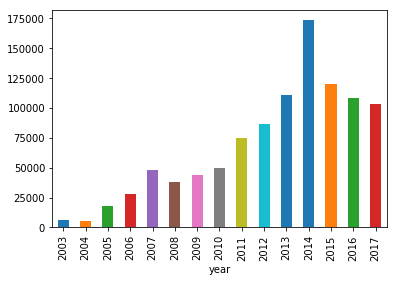

In [77]:
# SUM PRICES OVER THE YEARS
group_year_prices=phones_new.groupby('year')['approx_price_EUR'].sum()
group_year_prices.plot.bar()

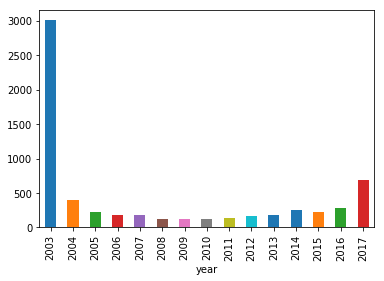

In [78]:
# MEAN PRICES PER YEAR
group_year_prices_mean=phones_new.groupby('year')['approx_price_EUR'].mean()
group_year_prices_mean.plot.bar()

# 2003 AND 2017 SEEMS TO BE WITH OUTLIERS - NEED TO BE CHECKED

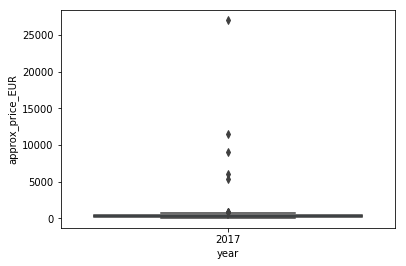

In [79]:

ax = sns.boxplot(x='year', y='approx_price_EUR', data=phones_new[phones_new['year']==2017])
# OVER 5000 EURO'S - not reasonable

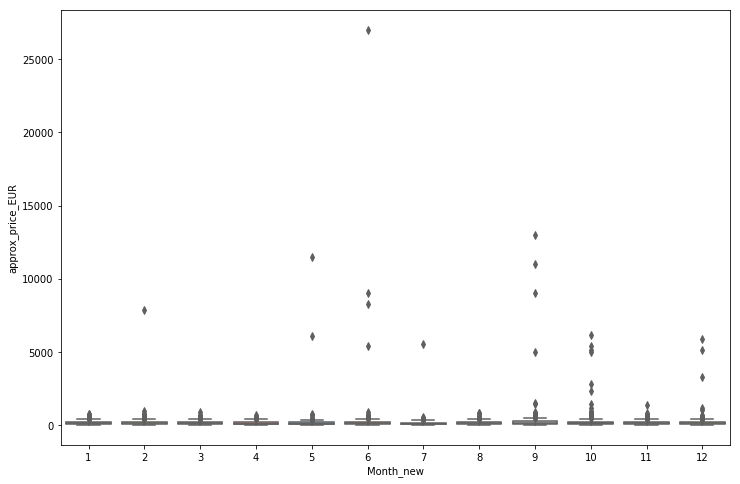

In [80]:
# Checking outliers by months
phones_new_month=phones_new[['Month_new','approx_price_EUR']]
plt.figure(figsize=(12,8))
ax = sns.boxplot(x="Month_new", y="approx_price_EUR", data=phones_new_month,palette="Set3")
plt.show()

#Several samples over ~1,000 euro, to be dropped


In [81]:
# DECLARE RANGES AND CHECK NUMBER OF SAMPLES IN EACH RANGE
bins = [0,100, 200, 300, 400, 500,600,700,800,900,1000, np.inf]
names = ['0-100','101-200', '201-300', '301-400', '401-500', '501-600','601-700','701-800','801-900','901-1000','1001+']

phones_new['Range'] = pd.cut(phones_new['approx_price_EUR'], bins, labels=names)
phones_new['Range'].value_counts(dropna=False)

0-100       1844
101-200     1728
201-300      819
301-400      309
401-500      156
501-600       55
601-700       33
1001+         28
701-800       18
801-900       10
901-1000       2
Name: Range, dtype: int64

In [82]:
# drop rows where price is over 1000 EURO
phones_new = phones_new.drop(phones_new[(phones_new['approx_price_EUR'] >=1000)].index)

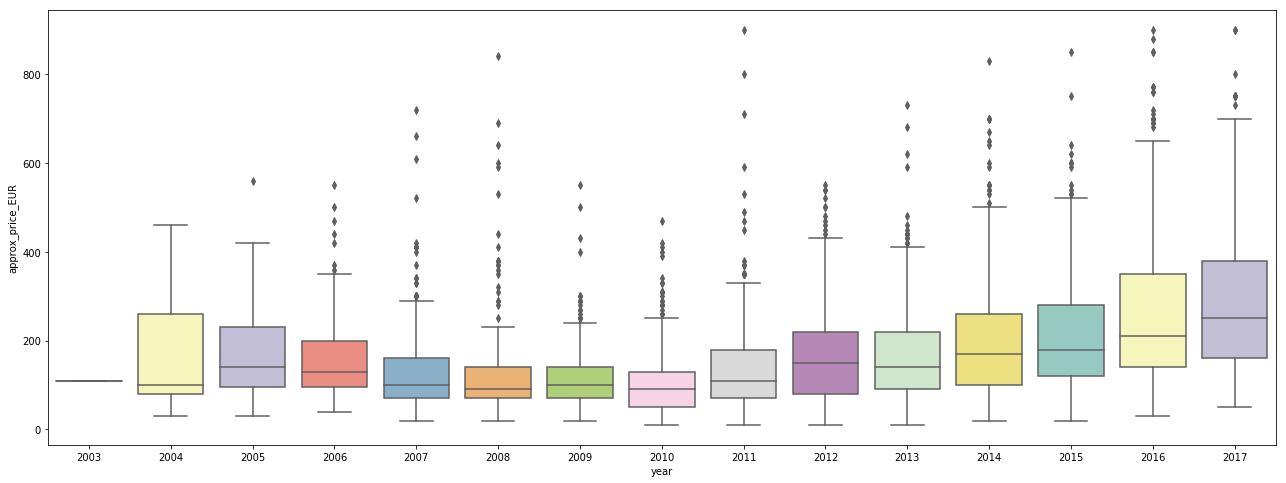

In [83]:
# Check prices after dropping outliers - yearly
phones_new_year=phones_new[['year','approx_price_EUR']]
plt.figure(figsize=(22,8))
ax = sns.boxplot(x="year", y="approx_price_EUR", data=phones_new_year,palette="Set3")
plt.show()

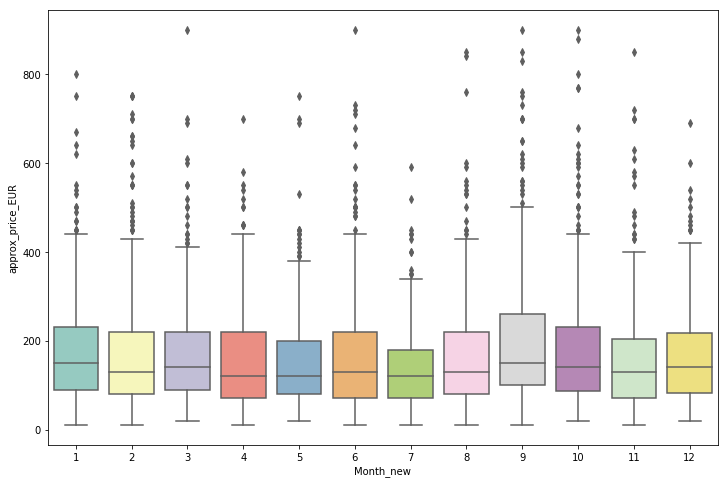

In [84]:
# Check prices after dropping outliers - monthly
phones_new_month=phones_new[['Month_new','approx_price_EUR']]
plt.figure(figsize=(12,8))
ax = sns.boxplot(x="Month_new", y="approx_price_EUR", data=phones_new_month,palette="Set3")
plt.show()

In [85]:
# creating subdata of numeric and bool features to see corr
phones_corr=phones_new[['approx_price_EUR','OS','weight_g','weight_oz', 'GPS_new', 'primary_cam_MP', 'secondary_cam_MP','GPU_new', 'battery_mah','battery_removable',
       'display_resolution_inches', 'screen_to_body_ratio_%', 'length_mm','brand_idx']]
phones_corr.corr(method ='kendall')

,approx_price_EUR,OS,weight_g,weight_oz,GPS_new,primary_cam_MP,secondary_cam_MP,GPU_new,battery_mah,display_resolution_inches,screen_to_body_ratio_%,length_mm,brand_idx
approx_price_EUR,1.000000,0.390443,0.483319,0.393728,0.433145,0.481305,0.440234,0.341186,0.437435,0.450440,0.489594,0.397510,-0.036488
OS,0.390443,1.000000,0.415906,0.371804,0.586010,0.359251,0.259043,0.375086,0.351907,0.366426,0.354346,0.334394,-0.155668
weight_g,0.483319,0.415906,1.000000,0.857274,0.507463,0.464918,0.427815,0.444383,0.664123,0.708358,0.550688,0.657263,-0.129089
weight_oz,0.393728,0.371804,0.857274,1.000000,0.472591,0.453538,0.377237,0.353177,0.555563,0.563174,0.489051,0.516838,-0.107328
GPS_new,0.433145,0.586010,0.507463,0.472591,1.000000,0.601401,0.473784,0.550016,0.544011,0.563222,0.555943,0.513580,-0.097858
primary_cam_MP,0.481305,0.359251,0.464918,0.453538,0.601401,1.000000,0.611281,0.438618,0.557748,0.600267,0.644859,0.516864,-0.044899
secondary_cam_MP,0.440234,0.259043,0.427815,0.377237,0.473784,0.611281,1.000000,0.419559,0.579766,0.574183,0.629735,0.566632,-0.039818
GPU_new,0.341186,0.375086,0.444383,0.353177,0.550016,0.438618,0.419559,1.000000,0.472068,0.507031,0.461181,0.487085,-0.109318
battery_mah,0.437435,0.351907,0.664123,0.555563,0.544011,0.557748,0.579766,0.472068,1.000000,0.812019,0.683340,0.775037,-0.082583
display_resolution_inches,0.450440,0.366426,0.708358,0.563174,0.563222,0.600267,0.574183,0.507031,0.812019,1.000000,0.798162,0.833828,-0.116648


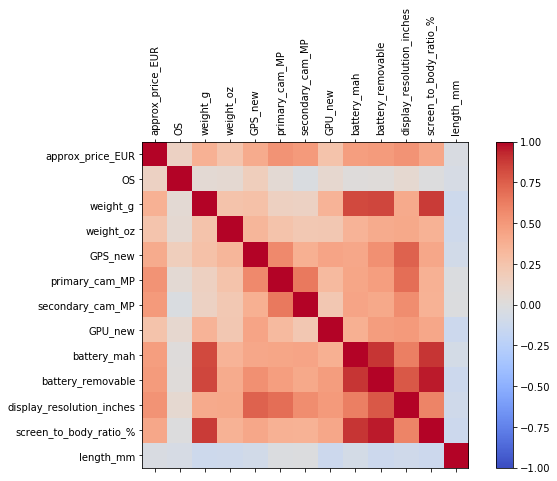

In [86]:
# Heatmap of corr - check important features
corr=phones_corr.corr()
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)
cax=ax.matshow(corr,cmap='coolwarm',vmin=-1, vmax=1)
fig.colorbar(cax)
ticks=np.arange(0,len(phones_corr.columns)-1,1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(phones_corr.columns)
ax.set_yticklabels(phones_corr.columns)
plt.show()

# Define the dataframe for the model 

In [92]:
phones_ready=phones_new[['approx_price_EUR','OS','weight_g','weight_oz', 'GPS_new', 'primary_cam_MP', 'secondary_cam_MP','GPU_new', 'battery_mah','battery_removable',
       'display_resolution_inches', 'screen_to_body_ratio_%', 'length_mm','width_mm','brand_idx']]


In [93]:
phones_ready=phones_ready.dropna(subset=['screen_to_body_ratio_%', 'battery_mah','length_mm','width_mm','battery_removable'])

phones_ready['weight_g'].fillna(phones_ready['weight_g'].mean(),inplace=True)
phones_ready['weight_oz'].fillna(phones_ready['weight_oz'].mean(),inplace=True)
phones_ready['battery_removable'] = phones_ready['battery_removable'].apply(lambda x: bool(x))

In [94]:
# Define ranges to each group for classification
bins = [0,50, 100, 150, 200, 250,300,350,400,450,500, np.inf]
names = [50,100, 150, 200, 250,300,350,400,450,500,800]

phones_ready['price_Range'] = pd.cut(phones_ready['approx_price_EUR'], bins, labels=names)
phones_ready['price_Range'].value_counts(dropna=False)

100    1007
150     862
200     575
50      415
250     412
300     311
350     162
800     121
400     114
450      88
500      48
Name: price_Range, dtype: int64

In [95]:

phones_ready.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4115 entries, 0 to 8608
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   approx_price_EUR           4115 non-null   float64 
 1   OS                         4115 non-null   int64   
 2   weight_g                   4115 non-null   float64 
 3   weight_oz                  4115 non-null   float64 
 4   GPS_new                    4115 non-null   bool    
 5   primary_cam_MP             4115 non-null   float64 
 6   secondary_cam_MP           4115 non-null   float64 
 7   GPU_new                    4115 non-null   int64   
 8   battery_mah                4115 non-null   float64 
 9   battery_removable          4115 non-null   bool    
 10  display_resolution_inches  4115 non-null   float64 
 11  screen_to_body_ratio_%     4115 non-null   float64 
 12  length_mm                  4115 non-null   float64 
 13  width_mm                   4115 n

In [98]:
phones_new['OS']

0       1
1       1
2       1
3       1
4       1
       ..
8591    1
8592    1
8594    1
8606    0
8608    1
Name: OS, Length: 5002, dtype: int64

In [96]:
phones_ready

,approx_price_EUR,OS,weight_g,weight_oz,GPS_new,primary_cam_MP,secondary_cam_MP,GPU_new,battery_mah,battery_removable,display_resolution_inches,screen_to_body_ratio_%,length_mm,width_mm,brand_idx,price_Range
0,170.0,1,260.000000,9.170000,True,13.00,2.0,3,3400.0,False,7.0,69.8,191.7,101.0,1,200
1,250.0,1,169.000000,5.960000,True,13.00,5.0,3,4080.0,True,5.5,71.7,153.8,75.6,1,250
4,230.0,1,166.000000,5.860000,True,13.00,13.0,3,4020.0,True,5.5,69.0,153.3,78.8,1,250
6,200.0,1,152.606661,4.759246,True,13.00,5.0,3,5000.0,False,5.5,70.3,154.0,77.0,1,200
7,110.0,1,125.000000,4.410000,True,8.00,5.0,3,2000.0,True,5.0,66.4,145.7,71.2,1,150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8585,170.0,1,403.000000,14.220000,True,3.15,0.0,0,3400.0,False,7.0,66.0,192.0,110.0,77,200
8587,250.0,1,120.000000,4.230000,True,5.00,0.0,0,1400.0,True,4.3,61.7,125.9,67.8,77,250
8591,200.0,1,100.000000,3.530000,True,3.15,0.0,0,1100.0,True,2.8,42.1,104.0,55.4,77,200
8594,170.0,1,110.000000,3.880000,True,3.15,0.0,1,1250.0,True,3.5,53.2,116.0,56.5,77,200


In [101]:
phones_ready.to_csv('GSMArena.csv', index=False)